**Multi-Label Text Classification Using BERT-Fine-Tuning (Toxic Comments Classification)**

**Detailed Article**: https://pysnacks.com/bert-text-classification-with-fine-tuning

Multi-class: https://colab.research.google.com/drive/1VuPv_SInihZIO9gwy1p0YqYQy76bwBuS








In [ ]:
#@title Install libraries
!pip install -q keras-bert keras-rectified-adam
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
#@title Set environment variables
import os
import contextlib
import tensorflow as tf

USE_TPU = False
os.environ['TF_KERAS'] = '1'

# @title Initialize TPU Strategy
if USE_TPU:
  TPU_WORKER = 'grpc://' + os.environ['COLAB_TPU_ADDR']
  resolver = tf.contrib.cluster_resolver.TPUClusterResolver(TPU_WORKER)
  tf.contrib.distribute.initialize_tpu_system(resolver)
  strategy = tf.contrib.distribute.TPUStrategy(resolver)

import os
import codecs
import numpy as np
from tqdm import tqdm

# Tensorflow Imports
import tensorflow as tf
from tensorflow.python import keras
import tensorflow.keras.backend as K

# Keras-bert imports
from keras_radam import RAdam
from keras_bert import Tokenizer
from keras_bert import get_custom_objects
from keras_bert import load_trained_model_from_checkpoint

os.environ['TF_KERAS'] = '1'

In [ ]:
#!wget -q https://storage.googleapis.com/bert_models/2018_10_18/uncased_L-12_H-768_A-12.zip
#!unzip -o uncased_L-12_H-768_A-12.zip


In [ ]:
# @title Download models and data

# Train/test Files
test_datapath = 'test.csv'
train_datapath = 'train.csv'

# Bert Files
pretrained_path = '%s/uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
checkpoint_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')


Mounted at /content/gdrive
-rw------- 1 root root 68802655 Jan 18  2018 '/content/gdrive/My Drive/pysnacks/resources/datasets/jigsaw-toxic-comment-classification-challenge/train.csv'
total 244926
-rw------- 1 root root 55201987 Apr 11 14:16 jigsaw-toxic-comment-classification-challenge.zip
-rw------- 1 root root  6279782 Jun 19  2018 sample_submission.csv
-rw------- 1 root root  1459715 Dec 11 04:00 sample_submission.csv.zip
-rw------- 1 root root 60354593 Jan 18  2018 test.csv
-rw------- 1 root root 24577258 Dec 11 04:00 test.csv.zip
-rw------- 1 root root  4976930 Jun 19  2018 test_labels.csv
-rw------- 1 root root  1527605 Dec 11 04:00 test_labels.csv.zip
-rw------- 1 root root 68802655 Jan 18  2018 train.csv
-rw------- 1 root root 27619914 Dec 11 04:00 train.csv.zip
total 430339
-rw------- 1 root root       288 Feb 20 18:55 bert_config.json
-rw------- 1 root root 440425712 Feb 20 18:57 bert_model.ckpt.data-00000-of-00001
-rw------- 1 root root      8528 Feb 20 18:57 bert_model.ckpt

In [ ]:
#@title Prepare training and test data
import pandas as pd

# Bert Model Constants
SEQ_LEN = 128
BATCH_SIZE = 16
EPOCHS = 2
LR = 2e-5

token_dict = {}
with codecs.open(vocab_path.replace('\\', ''), 'r', 'utf8') as reader:
    for line in reader:
        token = line.strip()
        token_dict[token] = len(token_dict)

tokenizer = Tokenizer(token_dict)

def load_data(comments, comment_labels):
    global tokenizer
    indices, labels = [], []
    for x in range(comments.shape[0]):
      ids, segments = tokenizer.encode(comments[x], max_len=SEQ_LEN)
      indices.append(ids)
      labels.append(comment_labels[x])

    items = list(zip(indices, labels))
    np.random.shuffle(items)
    indices, labels = zip(*items)
    indices = np.array(indices)
    mod = indices.shape[0] % BATCH_SIZE
    if mod > 0:
        indices, labels = indices[:-mod], labels[:-mod]
    return [indices, np.zeros_like(indices)], np.array(labels)


train_df = pd.read_csv(train_datapath.replace('\\', ''))
train_df = train_df.sample(frac=0.25,random_state = 42)

train_lines = train_df['comment_text'].values
labels_ordered = [
  'toxic',
  'severe_toxic',
  'obscene',
  'threat',
  'insult',
  'identity_hate'
]
train_labels = train_df[labels_ordered].values

print('train_lines.shape:', train_lines.shape)
print('train_labels.shape:', train_labels.shape)

train_x, train_y = load_data(train_lines, train_labels)

train_lines.shape: (39893,)
train_labels.shape: (39893, 6)


In [ ]:
# @title Build Custom (Fine-Tuned) Model 

# Load pretrained model
with strategy.scope() if USE_TPU else contextlib.suppress():
  model = load_trained_model_from_checkpoint(
    config_path.replace('\\', ''),
    checkpoint_path.replace('\\', ''),
    training=True,
    trainable=True,
    seq_len=SEQ_LEN,
  )
  
  # Add dense layer for classification
  inputs = model.inputs[:2]
  dense = model.get_layer('NSP-Dense').output
  outputs = keras.layers.Dense(
    units=len(labels_ordered),
    activation='sigmoid',
    name = 'Toxic-Categories-Dense'
  )(dense)
  model = keras.models.Model(inputs, outputs)

  model.compile(
      RAdam(lr=LR),
      loss='binary_crossentropy',
      metrics=['accuracy'],
  )

print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
Input-Token (InputLayer)        [(None, 128)]        0                                            
__________________________________________________________________________________________________
Input-Segment (InputLayer)      [(None, 128)]        0                                            
__________________________________________________________________________________________________
Embedding-Token (TokenEmbedding [(None, 128, 768), ( 23440896    Input-Token[0][0]              

In [ ]:
# @title Initialize Variables

sess = K.get_session()
uninitialized_variables = set([i.decode('ascii') for i in sess.run(tf.report_uninitialized_variables())])
init_op = tf.variables_initializer(
    [v for v in tf.global_variables() if v.name.split(':')[0] in uninitialized_variables]
)
sess.run(init_op)

In [ ]:
# @title Train
history = model.fit(
    train_x,
    train_y,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.33,
    shuffle=True,
)
model.save('toxic_comment_classif_50perc.h5')

Train on 26724 samples, validate on 13164 samples
Epoch 1/2
26724/26724 [==============================] - 1251s 47ms/sample - loss: 0.0858 - acc: 0.9660 - val_loss: 0.0450 - val_acc: 0.9822
Epoch 2/2
26724/26724 [==============================] - 1235s 46ms/sample - loss: 0.0404 - acc: 0.9845 - val_loss: 0.0431 - val_acc: 0.9827


dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


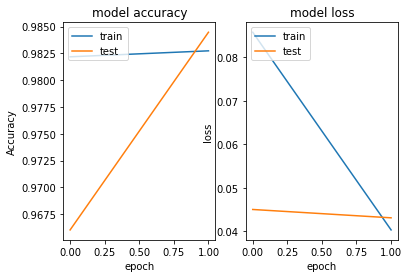

In [ ]:
#@title Plot model training progress
import matplotlib.pyplot as plt
import numpy
%matplotlib inline

# list all data in history
print(history.history.keys())
# summarize history for accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['val_acc'])
plt.plot(history.history['acc'])
plt.title('model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

plt.subplot(1, 2, 2)
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


In [ ]:
#@title Classifying texts
texts = [
  'You are an idiot!',
  'You are a  drug addict!',
  'I will kill you!',
  'I want to goto London',
  'You must create a model which predicts a probability of each type of toxicity for each comment.',
  'He was sad, his grand-parent got killed in a car accident!',
  'You stupid jackass! I will kill you.'

]

for text in texts:
  ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
  inpu = np.array(ids).reshape([1, SEQ_LEN])
  predicted = (model.predict([inpu,np.zeros_like(inpu)]) >= 0.5).astype(int)
  print ("%s: %s"%
    (
      text,
      [
        label
        for i, label in enumerate(labels_ordered)
        if predicted[0][i]
      ]
    )
  )

print('\n')
print (labels_ordered)
for text in texts:
  ids, segments = tokenizer.encode(text, max_len=SEQ_LEN)
  inpu = np.array(ids).reshape([1, SEQ_LEN])
  predicted = model.predict([inpu,np.zeros_like(inpu)])
  print ("%s: %s"% (predicted, text))


You are an idiot!: ['toxic', 'obscene', 'insult']
You are a  drug addict!: ['toxic']
I will kill you!: ['toxic', 'threat']
I want to goto London: []
You must create a model which predicts a probability of each type of toxicity for each comment.: []
He was sad, his grand-parent got killed in a car accident!: []
You stupid jackass! I will kill you.: ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult']


['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
[[0.9944135  0.07509044 0.68364394 0.01582807 0.96309525 0.06323443]]: You are an idiot!
[[0.8957073  0.00888687 0.07954308 0.01142967 0.47257832 0.05919608]]: You are a  drug addict!
[[0.95645237 0.2514637  0.21216995 0.75382674 0.28388628 0.08687323]]: I will kill you!
[[0.00077209 0.00016513 0.00066075 0.00021815 0.00048605 0.00021631]]: I want to goto London
[[0.00075552 0.00019819 0.00039548 0.00019068 0.0005849  0.00022588]]: You must create a model which predicts a probability of each type of toxicity for